In [ ]:
! pip install langchain_openai langgraph langgraph-swarm

In [1]:
import os

os.environ["ANTHROPIC_API_KEY"] = ""
os.environ["OPENAI_API_KEY"] = ""

# turn on langsmith tracing
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING_V2"] = "true"

In [1]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

## Customer support tools

In [4]:
import datetime
from collections import defaultdict
from typing import Callable

from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

# Mock data for tools
RESERVATIONS = defaultdict(lambda: {"flight_info": {}, "hotel_info": {}})
TOMORROW = (datetime.date.today() + datetime.timedelta(days=1)).isoformat()
FLIGHTS = [
    {
        "departure_airport": "BOS",
        "arrival_airport": "JFK",
        "airline": "Jet Blue",
        "date": TOMORROW,
        "id": "1",
    }
]
HOTELS = [
    {
        "location": "New York",
        "name": "McKittrick Hotel",
        "neighborhood": "Chelsea",
        "id": "1",
    }
]


# Flight tools
def search_flights(
    departure_airport: str,
    arrival_airport: str,
    date: str,
) -> list[dict]:
    """Search flights.

    Args:
        departure_airport: 3-letter airport code for the departure airport. If unsure, use the biggest airport in the area
        arrival_airport: 3-letter airport code for the arrival airport. If unsure, use the biggest airport in the area
        date: YYYY-MM-DD date
    """
    # return all flights for simplicity
    return FLIGHTS


def book_flight(
    flight_id: str,
    config: RunnableConfig,
) -> str:
    """Book a flight."""
    user_id = config["configurable"].get("user_id")
    flight = [flight for flight in FLIGHTS if flight["id"] == flight_id][0]
    RESERVATIONS[user_id]["flight_info"] = flight
    return "Successfully booked flight"


# Hotel tools
def search_hotels(location: str) -> list[dict]:
    """Search hotels.

    Args:
        location: offical, legal city name (proper noun)
    """
    # return all hotels for simplicity
    return HOTELS


def book_hotel(
    hotel_id: str,
    config: RunnableConfig,
) -> str:
    """Book a hotel."""
    user_id = config["configurable"].get("user_id")
    hotel = [hotel for hotel in HOTELS if hotel["id"] == hotel_id][0]
    RESERVATIONS[user_id]["hotel_info"] = hotel
    return "Successfully booked hotel"


# Handoff tools
transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant that can search for and book hotels.",
)
transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant that can search for and book flights.",
)


# Define agent prompt
def make_prompt(base_system_prompt: str) -> Callable[[dict, RunnableConfig], list]:
    def prompt(state: dict, config: RunnableConfig) -> list:
        user_id = config["configurable"].get("user_id")
        current_reservation = RESERVATIONS[user_id]
        system_prompt = (
            base_system_prompt
            + f"\n\nUser's active reservation: {current_reservation}"
            + f"Today is: {datetime.datetime.now()}"
        )
        return [{"role": "system", "content": system_prompt}] + state["messages"]

    return prompt


# Define agents
flight_assistant = create_react_agent(
    model,
    [search_flights, book_flight, transfer_to_hotel_assistant],
    prompt=make_prompt("You are a flight booking assistant"),
    name="flight_assistant",
)

hotel_assistant = create_react_agent(
    model,
    [search_hotels, book_hotel, transfer_to_flight_assistant],
    prompt=make_prompt("You are a hotel booking assistant"),
    name="hotel_assistant",
)

# Compile and run!
checkpointer = MemorySaver()
builder = create_swarm(
    [flight_assistant, hotel_assistant], default_active_agent="flight_assistant"
)

# Important: compile the swarm with a checkpointer to remember
# previous interactions and last active agent
app = builder.compile(checkpointer=checkpointer)

In [5]:
from IPython.display import Image, display

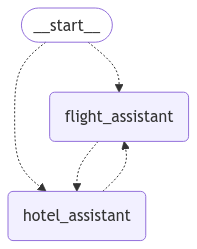

In [6]:
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4()), "user_id": "1"}}

In [8]:
def print_stream(stream):
    for ns, update in stream:
        for node, node_updates in update.items():
            if node_updates is None:
                continue

            if isinstance(node_updates, (dict, tuple)):
                node_updates_list = [node_updates]
            elif isinstance(node_updates, list):
                node_updates_list = node_updates
            else:
                raise ValueError(node_updates)

            for node_updates in node_updates_list:
                if isinstance(node_updates, tuple):
                    continue
                messages_key = next(
                    (k for k in node_updates.keys() if "messages" in k), None
                )
                if messages_key is not None:
                    node_updates[messages_key][-1].pretty_print()
                else:
                    pass



In [9]:
print_stream(
    app.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": "i am looking for a flight from boston to ny tomorrow",
                }
            ]
        },
        config,
        subgraphs=True,
    )
)

Namespace '('flight_assistant:84744415-e427-8fd1-f8cd-7709705ba2ba',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  search_flights (call_W97unU1M0IiCu0DrEmGDn5bm)
 Call ID: call_W97unU1M0IiCu0DrEmGDn5bm
  Args:
    departure_airport: BOS
    arrival_airport: JFK
    date: 2025-02-26



Namespace '('flight_assistant:84744415-e427-8fd1-f8cd-7709705ba2ba',)'
Update from node 'tools'
================================= Tool Message =================================
Name: search_flights

[{"departure_airport": "BOS", "arrival_airport": "JFK", "airline": "Jet Blue", "date": "2025-02-26", "id": "1"}]



Namespace '('flight_assistant:84744415-e427-8fd1-f8cd-7709705ba2ba',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant

I found a flight for you from Boston (BOS) to New York (JFK) for tomorrow, February 26, 2025:

- **

In [10]:
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": "yes please"}]},
        config,
        subgraphs=True,
    )
)

Namespace '('flight_assistant:e4a8a360-6a10-ffc1-9775-2db618706a62',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  book_flight (call_0yBH8MVZF8CZauwa0VrSIjDO)
 Call ID: call_0yBH8MVZF8CZauwa0VrSIjDO
  Args:
    flight_id: 1



Namespace '('flight_assistant:e4a8a360-6a10-ffc1-9775-2db618706a62',)'
Update from node 'tools'
================================= Tool Message =================================
Name: book_flight

Successfully booked flight



Namespace '('flight_assistant:e4a8a360-6a10-ffc1-9775-2db618706a62',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant

Your flight from Boston to New York with Jet Blue on February 26, 2025, has been successfully booked. Safe travels!



Namespace '()'
Update from node 'flight_assistant'
================================== Ai Message ===============================

In [11]:
print_stream(
    app.stream(
        {
            "messages": [
                {"role": "user", "content": "now i'd like to book a hotel as well"}
            ]
        },
        config,
        subgraphs=True,
    )
)

Namespace '('flight_assistant:470ea1ba-b5a2-6164-d6e1-b6c98519aefc',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  transfer_to_hotel_assistant (call_Ufumk8HdnMnO8ll294NLOyqI)
 Call ID: call_Ufumk8HdnMnO8ll294NLOyqI
  Args:



Namespace '()'
Update from node 'flight_assistant'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  transfer_to_hotel_assistant (call_Ufumk8HdnMnO8ll294NLOyqI)
 Call ID: call_Ufumk8HdnMnO8ll294NLOyqI
  Args:
Update from node 'flight_assistant'
================================= Tool Message =================================
Name: transfer_to_hotel_assistant

Successfully transferred to hotel_assistant
Update from node 'flight_assistant'
{'active_agent': 'hotel_assistant'}



Namespace '('hotel_assistant:96312da9-559b-cfc4-43eb-73ffd7549e5a',)'
Update from node 'agent'
================================

In [12]:
print_stream(
    app.stream(
        {"messages": [{"role": "user", "content": "yes please"}]},
        config,
        subgraphs=True,
    )
)

Namespace '('hotel_assistant:dafeb86b-a3cd-bd65-21b7-250fd7daf8f2',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  book_hotel (call_AyZooDJt5yGaiZikmIbzoLKk)
 Call ID: call_AyZooDJt5yGaiZikmIbzoLKk
  Args:
    hotel_id: 1



Namespace '('hotel_assistant:dafeb86b-a3cd-bd65-21b7-250fd7daf8f2',)'
Update from node 'tools'
================================= Tool Message =================================
Name: book_hotel

Successfully booked hotel



Namespace '('hotel_assistant:dafeb86b-a3cd-bd65-21b7-250fd7daf8f2',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: hotel_assistant

Your reservation at the McKittrick Hotel in Chelsea, New York, has been successfully booked. Enjoy your stay!



Namespace '()'
Update from node 'hotel_assistant'
================================== Ai Message ==================================
Name: hotel_

In [13]:
print_stream(
    app.stream(
        {
            "messages": [
                {"role": "user", "content": "i wanna talk to flight assistant now"}
            ]
        },
        config,
        subgraphs=True,
    )
)

Namespace '('hotel_assistant:813f3e95-62fe-2095-d6c7-07d52a6de1ad',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  transfer_to_flight_assistant (call_MpFQrEcnXvXdNBr2zCs0xgRk)
 Call ID: call_MpFQrEcnXvXdNBr2zCs0xgRk
  Args:



Namespace '()'
Update from node 'hotel_assistant'
================================== Ai Message ==================================
Name: hotel_assistant
Tool Calls:
  transfer_to_flight_assistant (call_MpFQrEcnXvXdNBr2zCs0xgRk)
 Call ID: call_MpFQrEcnXvXdNBr2zCs0xgRk
  Args:
Update from node 'hotel_assistant'
================================= Tool Message =================================
Name: transfer_to_flight_assistant

Successfully transferred to flight_assistant
Update from node 'hotel_assistant'
{'active_agent': 'flight_assistant'}



Namespace '('flight_assistant:56838261-9788-8e53-f605-c875e9c0336a',)'
Update from node 'agent'
================================